## 1.Aurelia Margin bin50 Reports

In [1]:
import scanpy as sc

In [2]:
# Aurelia Margin Info: 8546 spots * 20613 transcript_ids
st_AureliaMargin = sc.read_h5ad("./Data/AureliaMargin.bin50.normalized.h5ad")
st_AureliaMargin

AnnData object with n_obs × n_vars = 8546 × 20613
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'leiden', 'orig.ident', 'x', 'y'
    var: 'real_gene_name', 'n_cells', 'n_counts', 'mean_umi', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'old_name'
    uns: 'bin_size', 'bin_type', 'dendrogram_leiden', 'gene_exp_leiden', 'hvg', 'key_record', 'leiden_colors', 'leiden_resolution', 'log1p', 'merged', 'neighbors', 'omics', 'pca_variance_ratio', 'rank_genes_groups', 'resolution', 'result_keys', 'sn'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

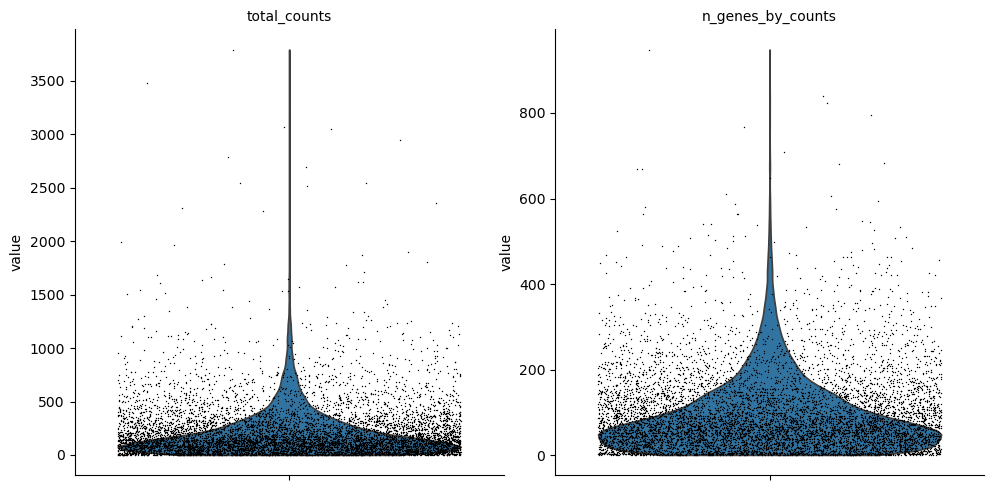

In [3]:
# Violin plots show the distribution of deduplicated MID count and gene types in each bin
sc.pl.violin(st_AureliaMargin, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

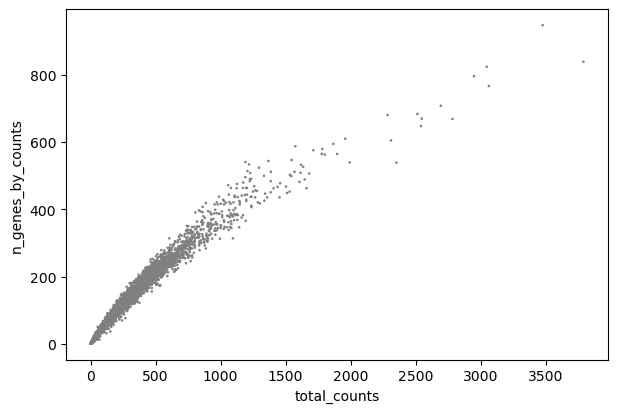

In [4]:
# Scatter QC plots
sc.pl.scatter(st_AureliaMargin, x='total_counts', y='n_genes_by_counts')

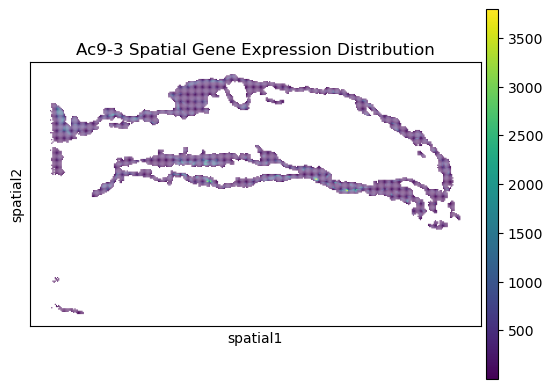

In [5]:
# Spatial Gene Expression Distribution
sc.pl.spatial(
    st_AureliaMargin, color='total_counts', spot_size=50, cmap='viridis',
    title="Ac9-3 Spatial Gene Expression Distribution"
)

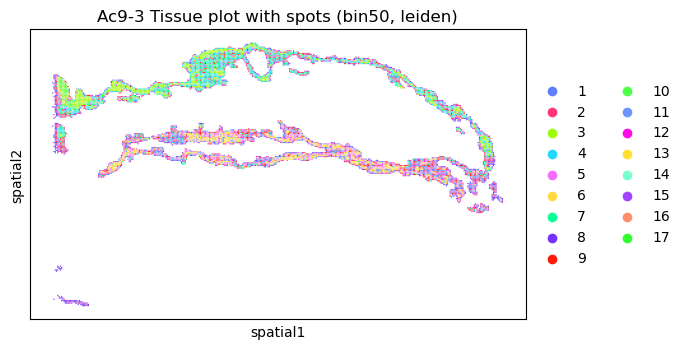

In [6]:
# Clustering spots (bin50) under tissue covered with the Leiden algorithm
sc.pl.spatial(
    st_AureliaMargin, color="leiden", spot_size=50,
    title="Ac9-3 Tissue plot with spots (bin50, leiden)"
)

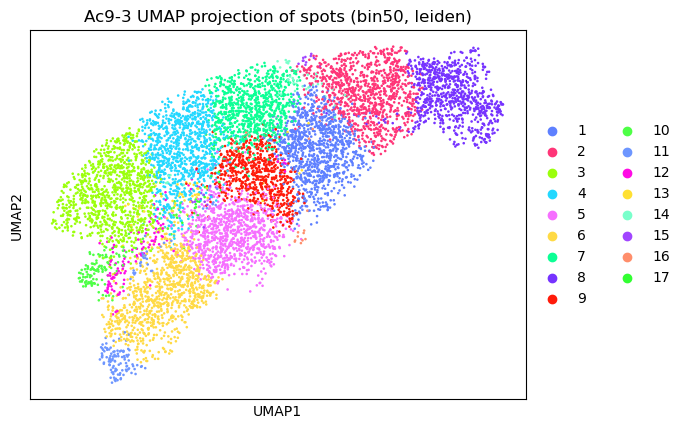

In [7]:
# UMAP projections of spots (bin50) colored by automated clustering
sc.pl.umap(
    st_AureliaMargin, color='leiden',
    title='Ac9-3 UMAP projection of spots (bin50, leiden)'
)

In [8]:
st_AureliaMargin.obs['leiden'].value_counts()

leiden
1     982
2     964
3     956
4     934
5     933
6     896
7     838
8     813
9     669
10    137
11    136
12    118
13     50
14     46
15     28
16     24
17     22
Name: count, dtype: int64

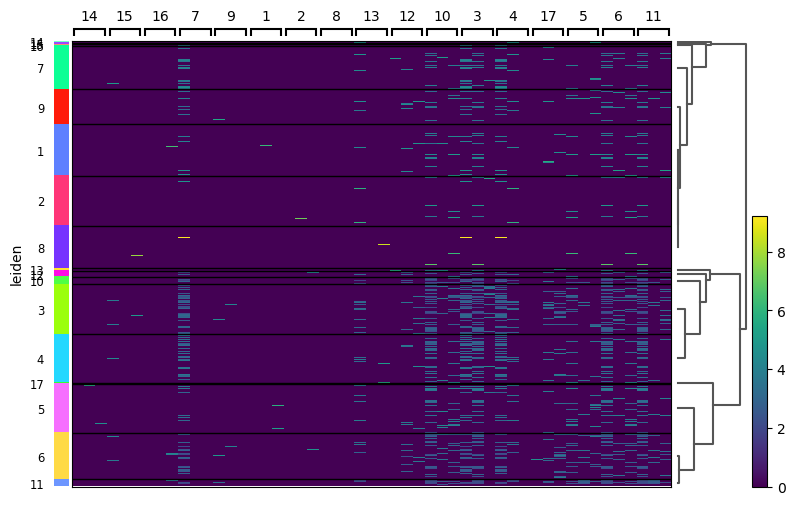

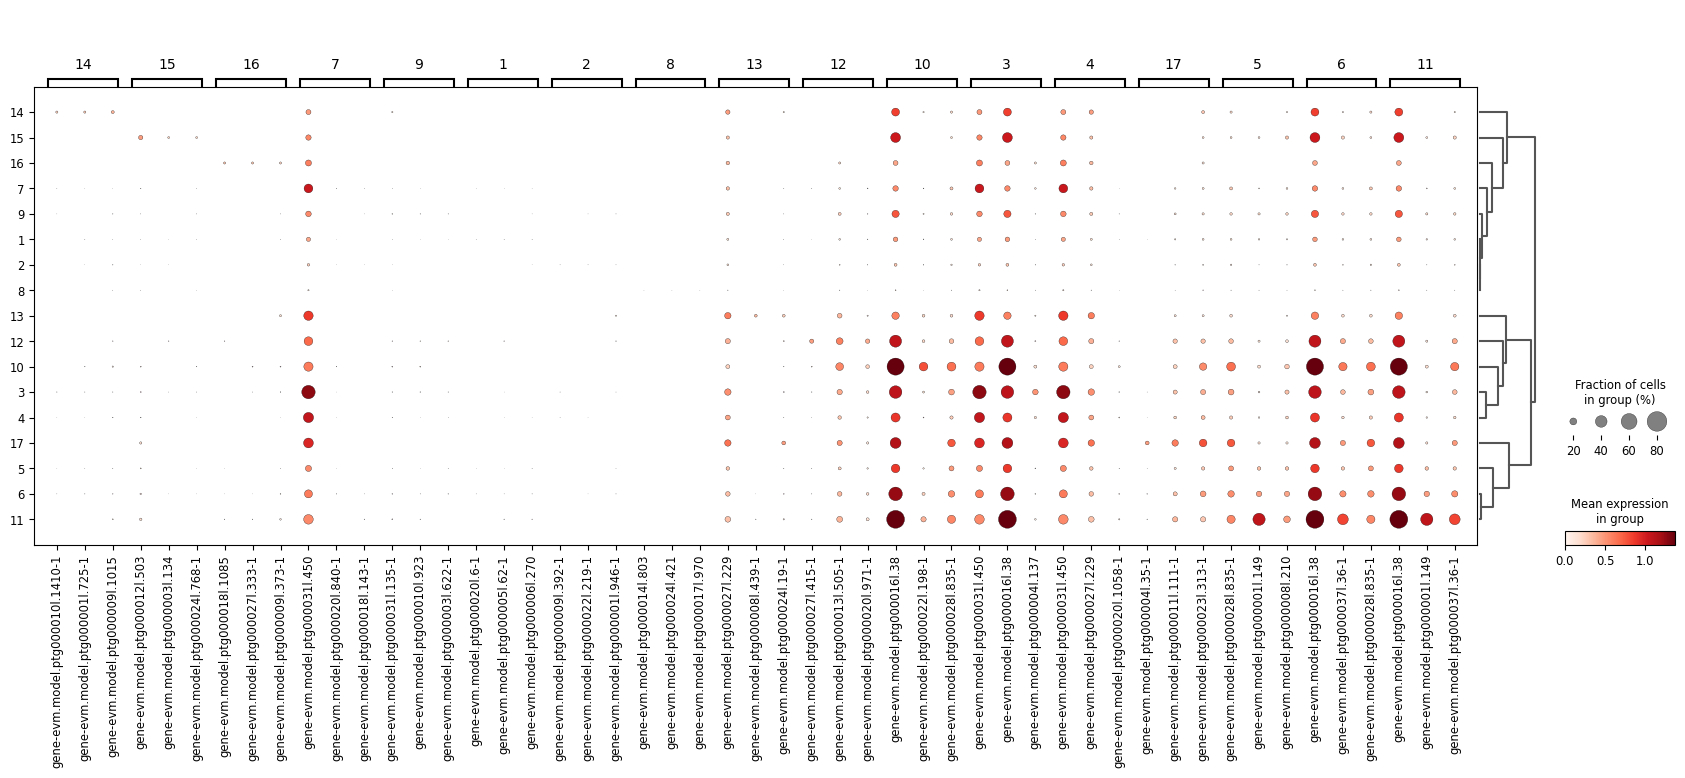

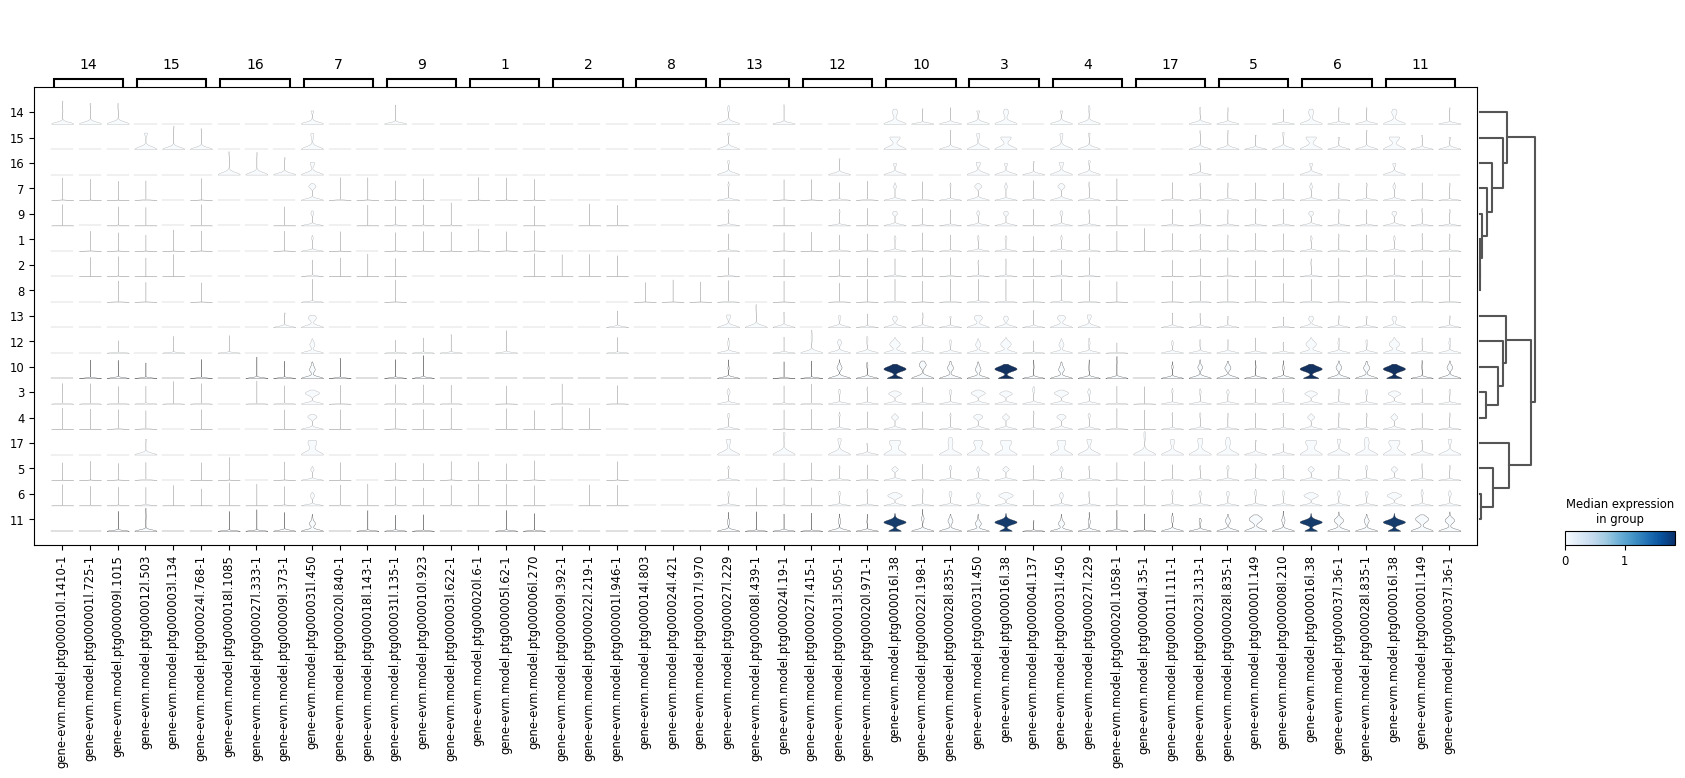

In [9]:
# Top Markers by Cluster heatmap / dotplot
sc.pl.rank_genes_groups_heatmap(st_AureliaMargin, n_genes=3, groupby='leiden', use_raw=True)
sc.pl.rank_genes_groups_dotplot(st_AureliaMargin, n_genes=3)
sc.pl.rank_genes_groups_stacked_violin(st_AureliaMargin, n_genes=3)

## 2.Hierarchical Clustering

In [10]:
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

In [11]:
# leiden linkage
linkage = st_AureliaMargin.uns["dendrogram_leiden"]["linkage"]
leiden_order = st_AureliaMargin.uns["dendrogram_leiden"]["categories_ordered"]
print(leiden_order)

# Hierarchical cluster
super_cluster_labels = fcluster(linkage, 3, criterion="maxclust")
print(super_cluster_labels)

['14' '15' '16' '7' '9' '1' '2' '8' '13' '12' '10' '3' '4' '17' '5' '6'
 '11']
[1 1 2 2 3 3 1 1 1 2 3 2 2 1 1 1 3]


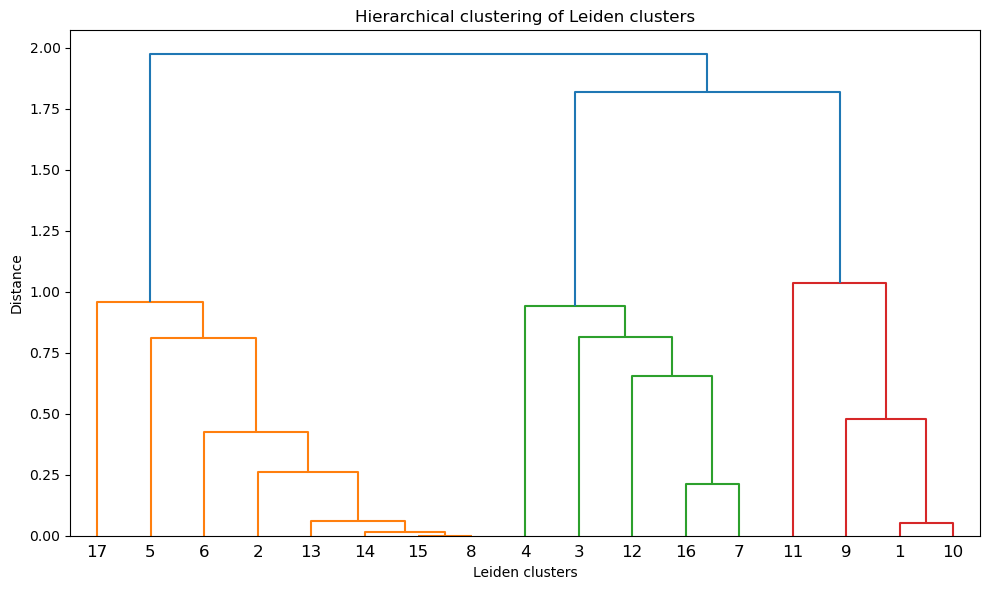

In [12]:
# plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(
    linkage,
    labels=leiden_order,
    orientation='top',
    color_threshold=None
)
plt.title("Hierarchical clustering of Leiden clusters")
plt.xlabel("Leiden clusters")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [13]:
# leiden cluster mapping
mapping = dict(zip(leiden_order, super_cluster_labels))
label_map = {1: "c1", 2: "c2", 3: "c3"}

st_AureliaMargin.obs["super_leiden"] = (
    st_AureliaMargin.obs["leiden"]
    .map(mapping)
    .map(label_map)
)

# super_leiden counts
print(st_AureliaMargin.obs["super_leiden"].value_counts())

super_leiden
c1    3752
c2    2870
c3    1924
Name: count, dtype: int64


In [14]:
# super_leiden categorical
st_AureliaMargin.obs["super_leiden"] = st_AureliaMargin.obs["super_leiden"].astype("category")

# super_leiden color
color_map = {
    "c1": "#ff7f0e",   # orange
    "c2": "#2ca02c",   # green
    "c3": "#d62728",   # red
}

# colors mapping
cats = st_AureliaMargin.obs["super_leiden"].cat.categories
st_AureliaMargin.uns["super_leiden_colors"] = [color_map[ct] for ct in cats]

print("Assigned colors:", st_AureliaMargin.uns["super_leiden_colors"])


Assigned colors: ['#ff7f0e', '#2ca02c', '#d62728']


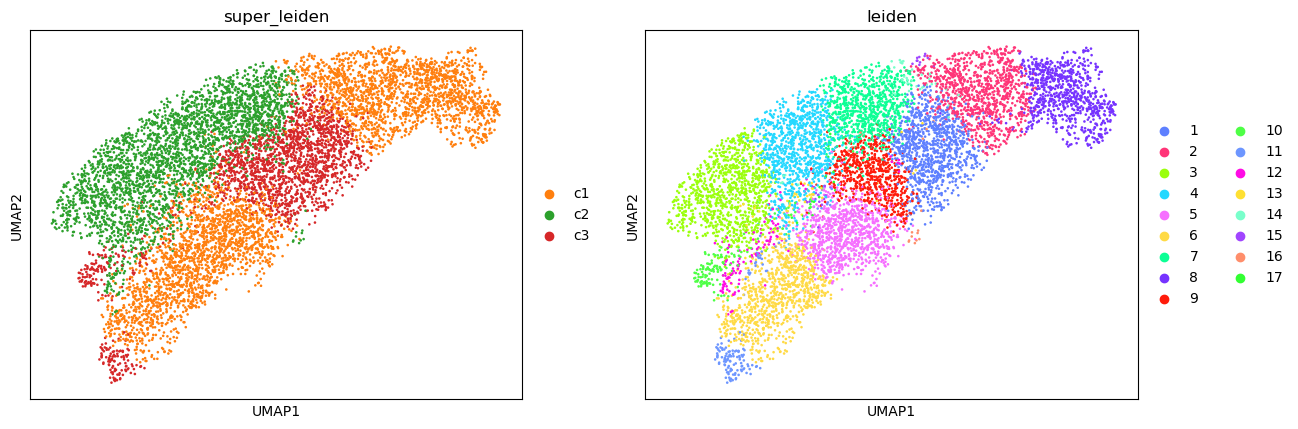

In [15]:
# super_leiden UMAP
sc.pl.umap(st_AureliaMargin, color=['super_leiden', 'leiden'])

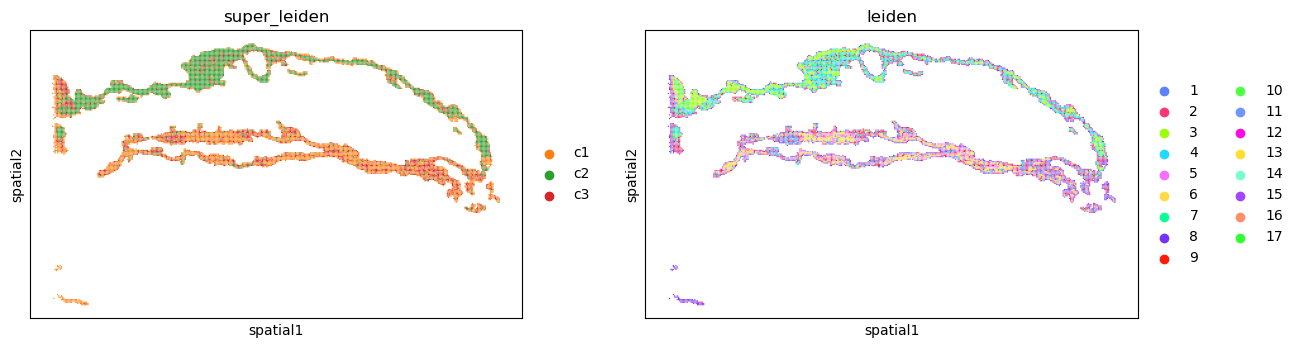

In [16]:
# super_leiden Spatial
sc.pl.spatial(st_AureliaMargin, color=['super_leiden', 'leiden'], spot_size=50)

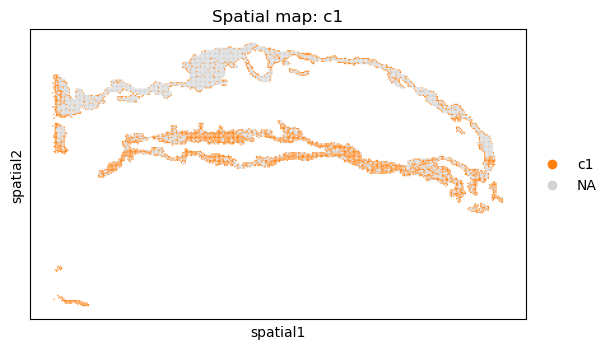

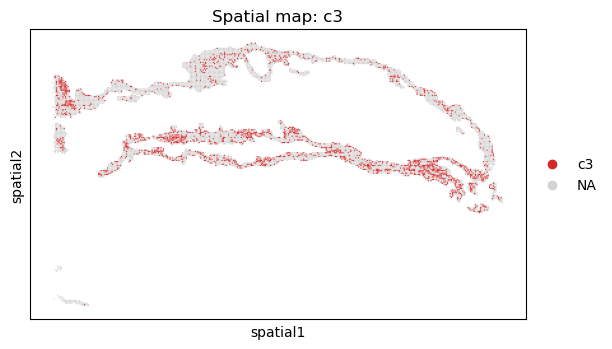

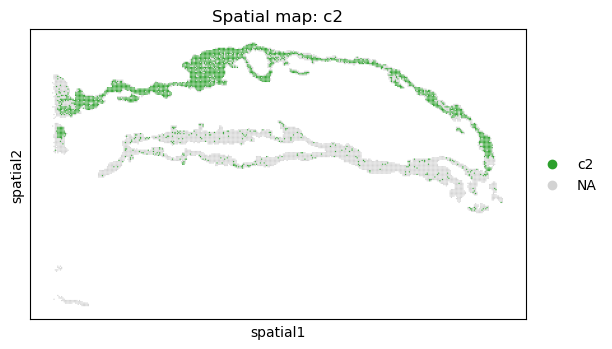

In [17]:
# each cluster in super_leiden
celltypes = st_AureliaMargin.obs["super_leiden"].unique().tolist()

for ct in celltypes:
    sc.pl.spatial(
        st_AureliaMargin,
        color="super_leiden",
        groups=[ct],
        spot_size=50,
        title=f"Spatial map: {ct}"
    )


## 3.Orthogroup Processing

### 3.1 transcripts to OGs mapping

In [18]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad


def map_transcripts_to_orthogroups(
    adata: ad.AnnData,
    og_map_path: str,
    save_path: str = None,
    agg_method: str = "sum"
) -> ad.AnnData:
    """
    Map transcript-level expression in an AnnData object to orthogroups (OGs),
    aggregate expression across transcripts belonging to the same OG, and
    return a new AnnData object at the OG level.

    Parameters
    ----------
    adata : AnnData
        Input AnnData object containing transcript-level expression.
    og_map_path : str
        Path to a CSV file containing two columns:
        `protein_id` and `orthogroup`, defining transcript-to-OG mapping.
    save_path : str, optional
        If provided, the output OG-level AnnData will be written to this path.
    agg_method : {"sum", "mean"}, optional
        Aggregation method for transcripts belonging to the same OG.
        Default is "sum".

    Returns
    -------
    AnnData
        An AnnData object with expression aggregated per orthogroup.
    """

    print("\n===== Mapping transcripts to orthogroups =====")
    print(f"Input AnnData: {adata}")
    adata = adata.copy()  # avoid modifying the original object

    # -------------------------------
    # 1. Report input dimension
    # -------------------------------
    print(f"Number of transcripts (vars) before mapping: {adata.n_vars}")

    # Store original gene/transcript IDs
    adata.var["raw_gene_id"] = adata.var_names

    # -------------------------------
    # 2. Load OG mapping table
    # -------------------------------
    og_df = pd.read_csv(og_map_path)
    if not {"protein_id", "orthogroup"}.issubset(og_df.columns):
        raise ValueError("OG map must contain columns: 'protein_id', 'orthogroup'.")

    og_map = og_df.set_index("protein_id")["orthogroup"].to_dict()
    unique_og_count = len(set(og_map.values()))

    print(f"OG mapping table loaded: {unique_og_count} unique OGs, {len(og_map)} total proteins.")

    # -------------------------------
    # 3. Build orthogroup column
    # -------------------------------
    adata.var["orthogroup"] = adata.var_names.map(lambda x: og_map.get(x, x))

    n_mapped = np.sum(adata.var["orthogroup"] != adata.var["raw_gene_id"])
    n_unmapped = np.sum(adata.var["orthogroup"] == adata.var["raw_gene_id"])

    print(f"Transcripts mapped to OGs: {n_mapped}")
    print(f"Transcripts not mapped (kept as unique IDs): {n_unmapped}")

    # -------------------------------
    # 4. Construct expression DataFrame
    # -------------------------------
    # Convert sparse matrix if necessary
    X = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X

    expr_df = pd.DataFrame(
        X,
        index=adata.obs_names,
        columns=adata.var["orthogroup"].values,  # renamed to OG or original
    )

    og_dim_before = expr_df.shape[1]

    # -------------------------------
    # 5. Aggregate expression per OG
    # -------------------------------
    if agg_method == "sum":
        expr_og = expr_df.groupby(expr_df.columns, axis=1).sum()
    elif agg_method == "mean":
        expr_og = expr_df.groupby(expr_df.columns, axis=1).mean()
    else:
        raise ValueError("agg_method must be 'sum' or 'mean'.")

    og_dim_after = expr_og.shape[1]

    print(f"Expression matrix before aggregation: {og_dim_before} columns (with duplicates).")
    print(f"Expression matrix after aggregation:  {og_dim_after} unique OGs.")

    # -------------------------------
    # 6. Build new AnnData object
    # -------------------------------
    adata_og = ad.AnnData(
        X=expr_og.values,
        obs=adata.obs.copy(),
        var=pd.DataFrame(index=expr_og.columns)
    )

    # Transfer metadata
    adata_og.uns = adata.uns.copy()
    adata_og.obsm = adata.obsm.copy()

    print(f"Output AnnData: cells = {adata_og.n_obs}, OGs = {adata_og.n_vars}")

    # -------------------------------
    # 7. Save if requested
    # -------------------------------
    if save_path is not None:
        adata_og.write_h5ad(save_path)
        print(f"OG-level AnnData saved to: {save_path}")

    print("===== Mapping completed. =====\n")
    return adata_og

### 3.2 Aurelia mapped

In [19]:
# Aurelia
st_og_map_path = f"./Data/Aurelia.protein_to_orthogroup.csv"
st_AureliaMargin_og = map_transcripts_to_orthogroups(st_AureliaMargin, st_og_map_path)
print(st_AureliaMargin_og)


===== Mapping transcripts to orthogroups =====
Input AnnData: AnnData object with n_obs × n_vars = 8546 × 20613
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'leiden', 'orig.ident', 'x', 'y', 'super_leiden'
    var: 'real_gene_name', 'n_cells', 'n_counts', 'mean_umi', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'old_name'
    uns: 'bin_size', 'bin_type', 'dendrogram_leiden', 'gene_exp_leiden', 'hvg', 'key_record', 'leiden_colors', 'leiden_resolution', 'log1p', 'merged', 'neighbors', 'omics', 'pca_variance_ratio', 'rank_genes_groups', 'resolution', 'result_keys', 'sn', 'super_leiden_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
Number of transcripts (vars) before mapping: 20613
OG mapping table loaded: 8806 unique OGs, 27557 total proteins.
Transcripts mapped to OGs: 14524
Transcripts not mapped (kept as unique IDs): 6089


/tmp/ipykernel_3921349/2430422244.py:90: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  expr_og = expr_df.groupby(expr_df.columns, axis=1).sum()


Expression matrix before aggregation: 20613 columns (with duplicates).
Expression matrix after aggregation:  14087 unique OGs.
Output AnnData: cells = 8546, OGs = 14087
===== Mapping completed. =====

AnnData object with n_obs × n_vars = 8546 × 14087
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'leiden', 'orig.ident', 'x', 'y', 'super_leiden'
    uns: 'bin_size', 'bin_type', 'dendrogram_leiden', 'gene_exp_leiden', 'hvg', 'key_record', 'leiden_colors', 'leiden_resolution', 'log1p', 'merged', 'neighbors', 'omics', 'pca_variance_ratio', 'rank_genes_groups', 'resolution', 'result_keys', 'sn', 'super_leiden_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'


In [20]:
st_AureliaMargin_og.obs.index.name = "CellName"
st_AureliaMargin_og.obs

total_counts  n_genes_by_counts  pct_counts_mt leiden  \
CellName                                                                
7730941138250              5                  1            0.0      8   
7730941138650              2                  1            0.0      8   
7730941139200              1                  1            0.0      8   
7730941139950              1                  1            0.0      8   
7945689502750             12                  5            0.0      8   
...                      ...                ...            ...    ...   
83322365552550           111                 58            0.0      7   
83537113917200             1                  1            0.0      8   
83537113917250             7                  5            0.0      8   
83537113917300             9                  5            0.0      8   
83537113917350            23                 11            0.0      2   

               orig.ident      x      y super_leiden  
CellName                                              
7730941138250      sample   1800   5450           c1  
7730941138650      sample   1800   5850           c1  
7730941139200      sample   1800   6400           c1  
7730941139950      sample   1800   7150           c1  
7945689502750      sample   1850   5150           c1  
...                   ...    ...    ...          ...  
83322365552550     sample  19400  10150           c2  
83537113917200     sample  19450  10000           c1  
83537113917250     sample  19450  10050           c1  
83537113917300     sample  19450  10100           c1  
83537113917350     sample  19450  10150           c1  

[8546 rows x 8 columns]

In [21]:
st_AureliaMargin_og.var.index.name = "OrthoGene"
st_AureliaMargin_og.var

Empty DataFrame
Columns: []
Index: [OG0000000, OG0000002, OG0000003, OG0000005, OG0000006, OG0000007, OG0000008, OG0000009, OG0000010, OG0000011, OG0000012, OG0000013, OG0000015, OG0000016, OG0000017, OG0000019, OG0000020, OG0000023, OG0000024, OG0000025, OG0000026, OG0000027, OG0000028, OG0000029, OG0000030, OG0000031, OG0000032, OG0000033, OG0000034, OG0000035, OG0000036, OG0000037, OG0000038, OG0000039, OG0000040, OG0000041, OG0000042, OG0000043, OG0000044, OG0000045, OG0000046, OG0000047, OG0000049, OG0000050, OG0000052, OG0000053, OG0000054, OG0000055, OG0000056, OG0000057, OG0000058, OG0000059, OG0000060, OG0000061, OG0000062, OG0000064, OG0000065, OG0000066, OG0000067, OG0000069, OG0000070, OG0000071, OG0000072, OG0000073, OG0000074, OG0000075, OG0000076, OG0000077, OG0000078, OG0000080, OG0000081, OG0000082, OG0000085, OG0000086, OG0000087, OG0000088, OG0000091, OG0000093, OG0000094, OG0000095, OG0000096, OG0000098, OG0000099, OG0000100, OG0000101, OG0000102, OG0000104, OG0000105, OG0000106, OG0000107, OG0000108, OG0000109, OG0000110, OG0000111, OG0000112, OG0000113, OG0000114, OG0000115, OG0000116, OG0000117, ...]

[14087 rows x 0 columns]

In [22]:
# save Aurelia OGs adata
raw_Aurelia_og_path = "./Data/AureliaMargin.bin50.OGs.normalized.h5ad"
st_AureliaMargin_og.write(raw_Aurelia_og_path)

In [23]:
# save Aurelia OGs
st_AureliaMargin_og.var_names.to_series().to_csv('./Data/AureliaMargin.bin50.OGs.txt', index=False, header=False)

### 3.3 Clytia Medusa mapped

In [24]:
# Clytia
sc_adata_path = f"./Data/ClytiaMedusa.sc.normalized.h5ad"
sc_og_map_path = f"./Data/Clytia.protein_to_orthogroup.csv"

sc_Clytia = sc.read_h5ad(sc_adata_path)
sc_Clytia_og = map_transcripts_to_orthogroups(sc_Clytia, sc_og_map_path)
print(sc_Clytia_og)


===== Mapping transcripts to orthogroups =====
Input AnnData: AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'UMI Count'
    uns: 'annosSub_colors', 'annos_colors'
    obsm: 'X_umap'
Number of transcripts (vars) before mapping: 46716
OG mapping table loaded: 8524 unique OGs, 26832 total proteins.
Transcripts mapped to OGs: 15613
Transcripts not mapped (kept as unique IDs): 31103


/tmp/ipykernel_3921349/2430422244.py:90: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  expr_og = expr_df.groupby(expr_df.columns, axis=1).sum()


Expression matrix before aggregation: 46716 columns (with duplicates).
Expression matrix after aggregation:  38770 unique OGs.
Output AnnData: cells = 13673, OGs = 38770
===== Mapping completed. =====

AnnData object with n_obs × n_vars = 13673 × 38770
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'UMI Count'
    uns: 'annosSub_colors', 'annos_colors'
    obsm: 'X_umap'


In [25]:
sc_Clytia_og.obs.index.name = "CellName"
sc_Clytia_og.obs

batch  cellRanger_louvain    fed  orgID  \
CellName                                                      
AAACCTGAGAGGGCTT-1      0                  10   True      3   
AAACCTGAGAGGTTAT-1      0                   4  False      9   
AAACCTGAGCGAGAAA-1      0                   3   True      3   
AAACCTGAGCGTGTCC-1      0                  15  False     10   
AAACCTGAGGATTCGG-1      0                   3  False      8   
...                   ...                 ...    ...    ...   
TTTGTCAGTGGACGAT-2      1                  24   True      4   
TTTGTCATCATCTGTT-2      1                   2  False      7   
TTTGTCATCGCCTGAG-2      1                   6  False      7   
TTTGTCATCTAACGGT-2      1                  22   True      3   
TTTGTCATCTGAGTGT-2      1                   0  False      9   

                                  annos                     annosSub  \
CellName                                                               
AAACCTGAGAGGGCTT-1           Nematocyte  Differentiating Nematocytes   
AAACCTGAGAGGTTAT-1     Epidermal/Muscle          Manubrium Epidermis   
AAACCTGAGCGAGAAA-1           Gastroderm            GastroDigestive-A   
AAACCTGAGCGTGTCC-1           Gastroderm            GastroDigestive-D   
AAACCTGAGGATTCGG-1           Gastroderm            GastroDigestive-A   
...                                 ...                          ...   
TTTGTCAGTGGACGAT-2           Gastroderm            GastroDigestive-F   
TTTGTCATCATCTGTT-2  Stem Cell/Germ Cell               Medium Oocytes   
TTTGTCATCGCCTGAG-2               Neural    Neural Cells Early Stages   
TTTGTCATCTAACGGT-2           Gland Cell                Gland Cells-A   
TTTGTCATCTGAGTGT-2  Stem Cell/Germ Cell                      i-Cells   

                    UMI Count  
CellName                       
AAACCTGAGAGGGCTT-1     2099.0  
AAACCTGAGAGGTTAT-1     1643.0  
AAACCTGAGCGAGAAA-1      304.0  
AAACCTGAGCGTGTCC-1     4411.0  
AAACCTGAGGATTCGG-1     4616.0  
...                       ...  
TTTGTCAGTGGACGAT-2     2663.0  
TTTGTCATCATCTGTT-2      600.0  
TTTGTCATCGCCTGAG-2      396.0  
TTTGTCATCTAACGGT-2    28657.0  
TTTGTCATCTGAGTGT-2      653.0  

[13673 rows x 7 columns]

In [26]:
sc_Clytia_og.var.index.name = "OrthoGene"
sc_Clytia_og.var

Empty DataFrame
Columns: []
Index: [OG0000000, OG0000002, OG0000003, OG0000004, OG0000005, OG0000006, OG0000007, OG0000008, OG0000009, OG0000010, OG0000011, OG0000012, OG0000013, OG0000015, OG0000016, OG0000017, OG0000018, OG0000020, OG0000024, OG0000025, OG0000026, OG0000027, OG0000028, OG0000029, OG0000030, OG0000031, OG0000032, OG0000033, OG0000035, OG0000036, OG0000037, OG0000038, OG0000040, OG0000041, OG0000042, OG0000043, OG0000044, OG0000045, OG0000046, OG0000047, OG0000048, OG0000049, OG0000050, OG0000052, OG0000053, OG0000054, OG0000055, OG0000056, OG0000057, OG0000058, OG0000059, OG0000060, OG0000061, OG0000062, OG0000064, OG0000065, OG0000067, OG0000068, OG0000069, OG0000070, OG0000071, OG0000072, OG0000073, OG0000074, OG0000075, OG0000076, OG0000077, OG0000078, OG0000080, OG0000081, OG0000082, OG0000084, OG0000086, OG0000087, OG0000088, OG0000089, OG0000091, OG0000093, OG0000094, OG0000095, OG0000096, OG0000098, OG0000099, OG0000100, OG0000101, OG0000102, OG0000103, OG0000104, OG0000105, OG0000106, OG0000107, OG0000108, OG0000109, OG0000110, OG0000111, OG0000112, OG0000113, OG0000114, OG0000115, OG0000116, ...]

[38770 rows x 0 columns]

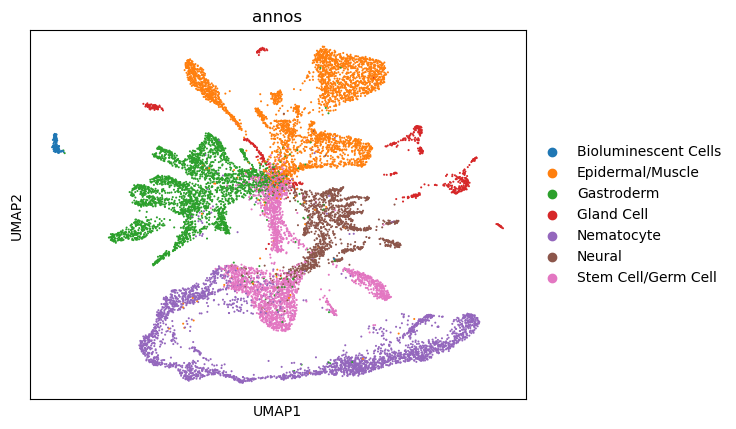

In [27]:
sc.pl.umap(sc_Clytia_og, color=['annos'])

In [28]:
sc_Clytia_og.obs['annos'].value_counts()

annos
Epidermal/Muscle        3254
Gastroderm              2921
Nematocyte              2819
Stem Cell/Germ Cell     2540
Neural                  1387
Gland Cell               634
Bioluminescent Cells     118
Name: count, dtype: int64

In [29]:
# save Clytia OGs adata
raw_Clytia_og_path = "./Data/ClytiaMedusa.sc.OGs.normalized.h5ad"
sc_Clytia_og.write(raw_Clytia_og_path)

In [30]:
# save Clytia OGs
sc_Clytia_og.var_names.to_series().to_csv('./Data/ClytiaMedusa.sc.OGs.txt', index=False, header=False)

## 4.OGs Markers of sc_Clytia and st_AureliaMargin

In [31]:
# Marker genes (orthogroups) grouped by cell type
markers_dict = {
    "Epidermal/Muscle": ['OG0000432', 'OG0002736', 'OG0001527', 'OG0000253'],
    "Nematocyte":       ['OG0011646', 'OG0001361'],
    "Neural":           ['OG0000166', 'OG0000393']
}


=== Epidermal/Muscle-related OGs markers ===


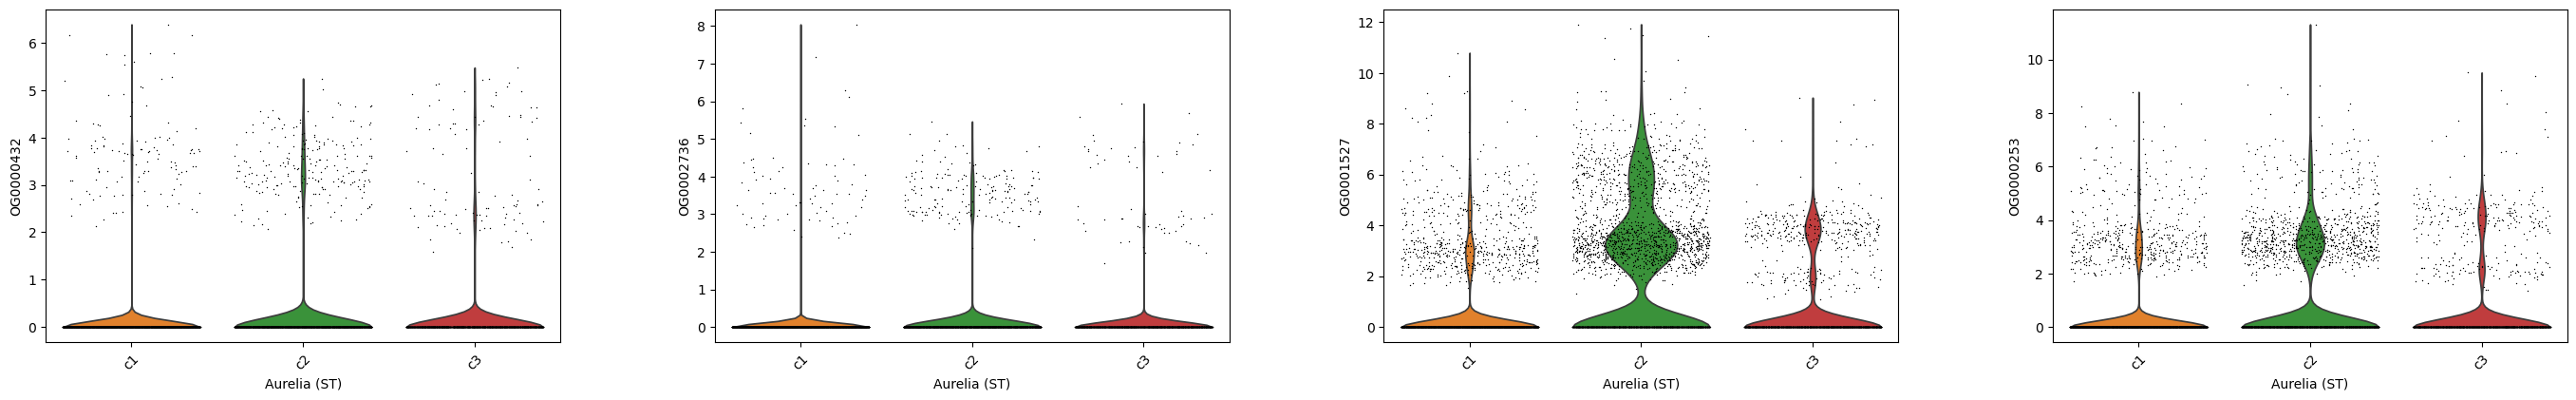

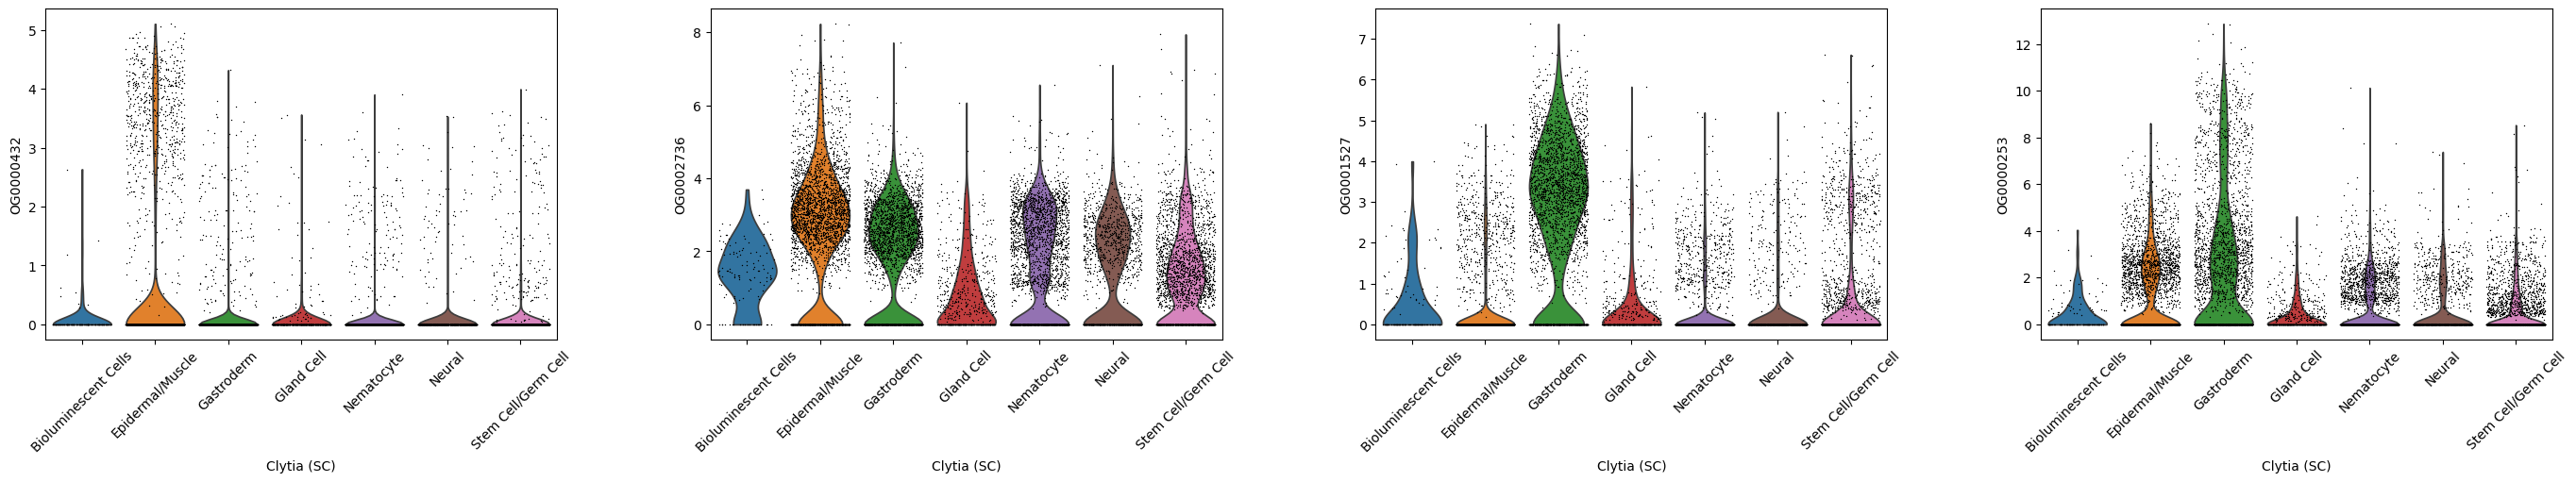


=== Nematocyte-related OGs markers ===


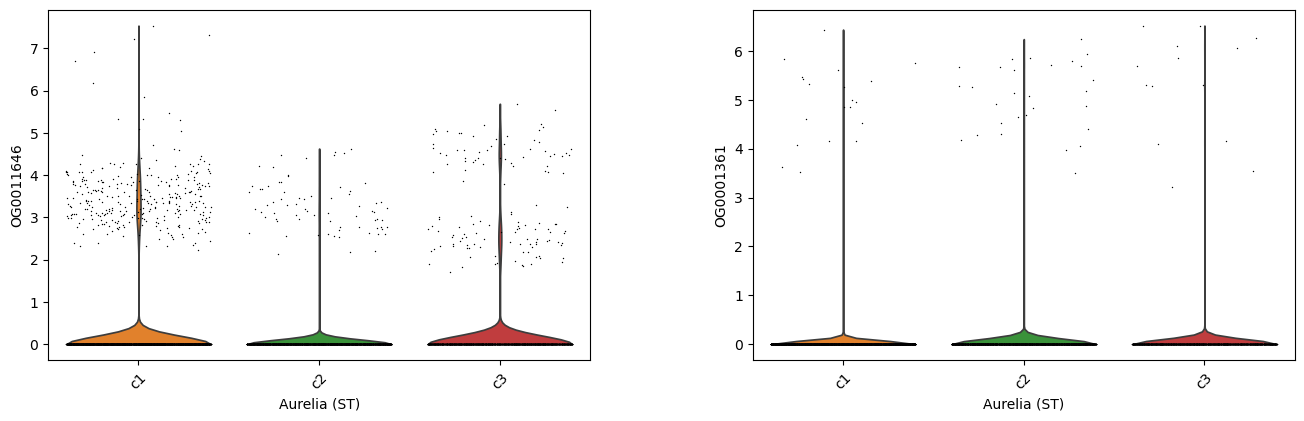

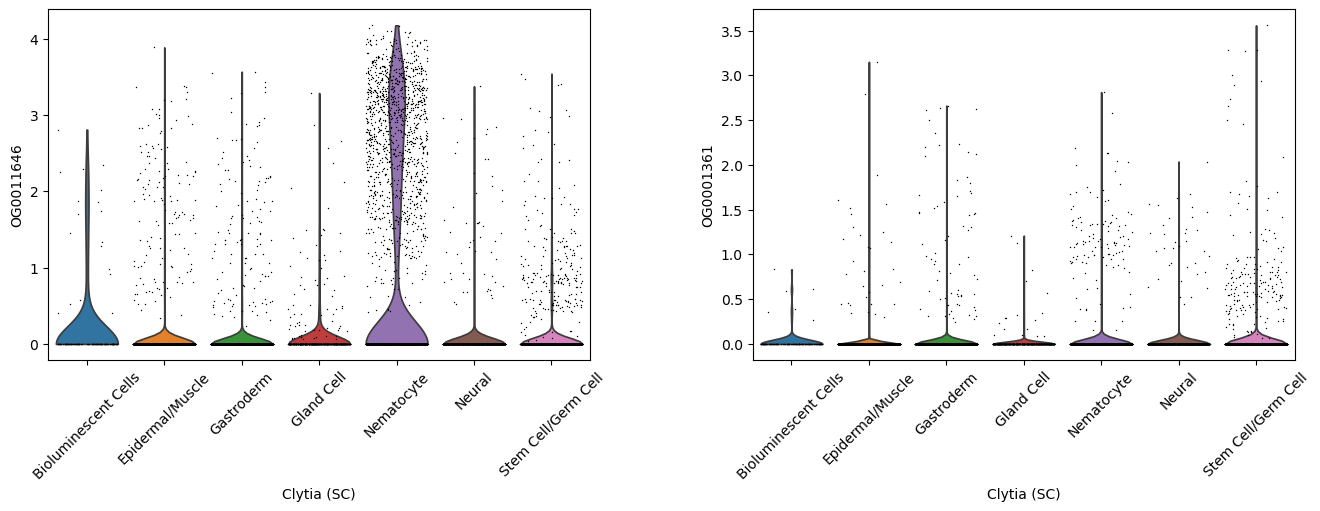


=== Neural-related OGs markers ===


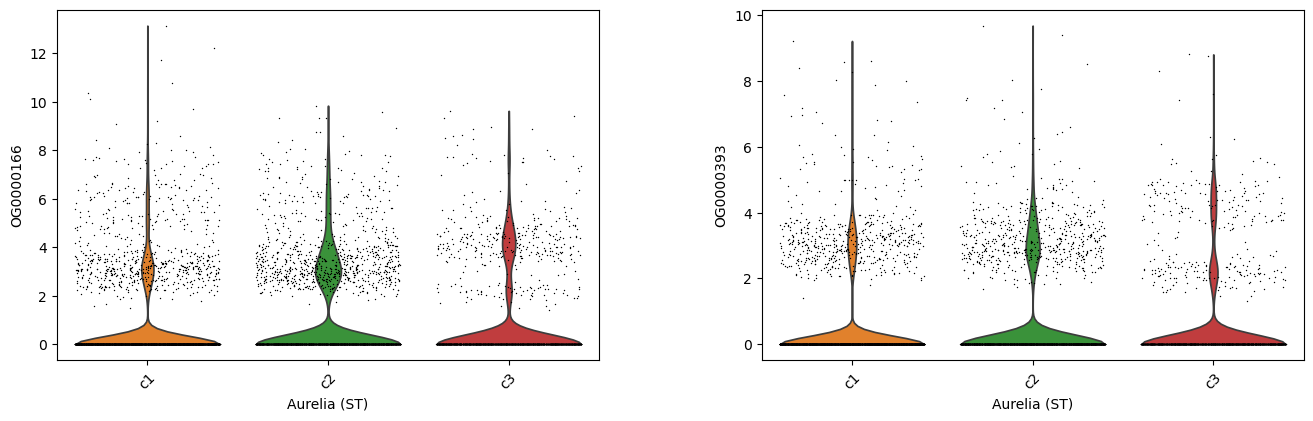

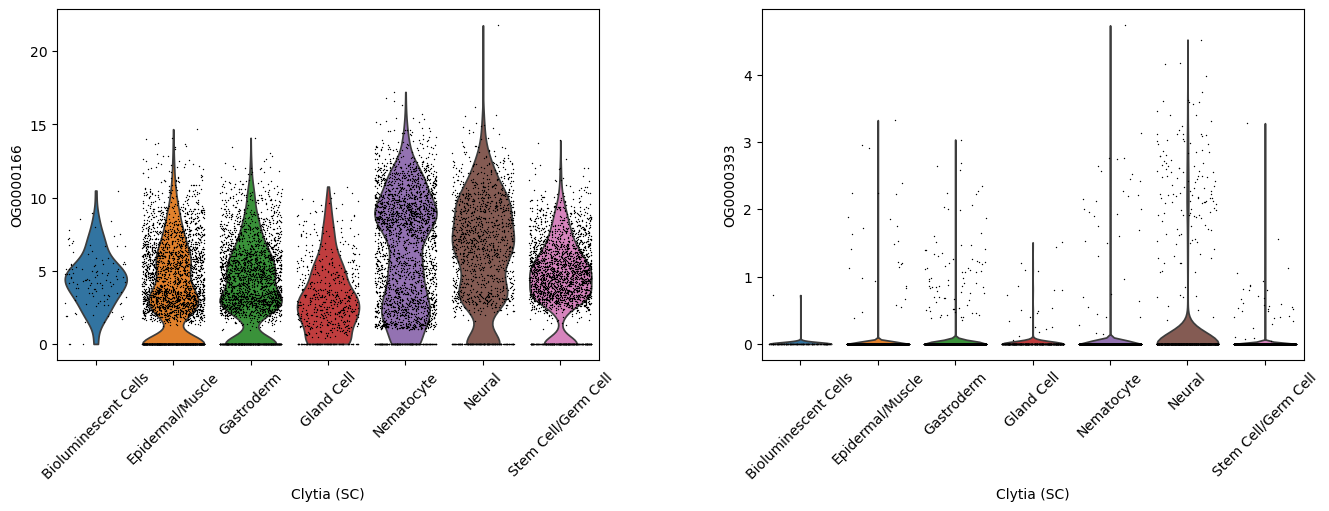

In [32]:
# Loop through cell-type marker groups and plot violins
for celltype, og_list in markers_dict.items():
    print(f"\n=== {celltype}-related OGs markers ===")

    # --- AureliaMargin-ST ---
    axs = sc.pl.violin(
        st_AureliaMargin_og,
        keys=og_list,
        groupby="super_leiden",
        jitter=0.4,
        rotation=45,
        stripplot=True,
        multi_panel=True,
        show=False      # ⭐ allow modifying axes before display
    )
    # When multi_panel=True, axs is a list of Axes
    for ax in axs:
        ax.set_xlabel("Aurelia (ST)")
    plt.show()

    # --- ClytiaMedusa-SC ---
    axs = sc.pl.violin(
        sc_Clytia_og,
        keys=og_list,
        groupby="annos",
        jitter=0.4,
        rotation=45,
        stripplot=True,
        multi_panel=True,
        show=False
    )
    for ax in axs:
        ax.set_xlabel("Clytia (SC)")
    plt.show()



=== Epidermal/Muscle-related OGs markers ===
AureliaMargin-ST


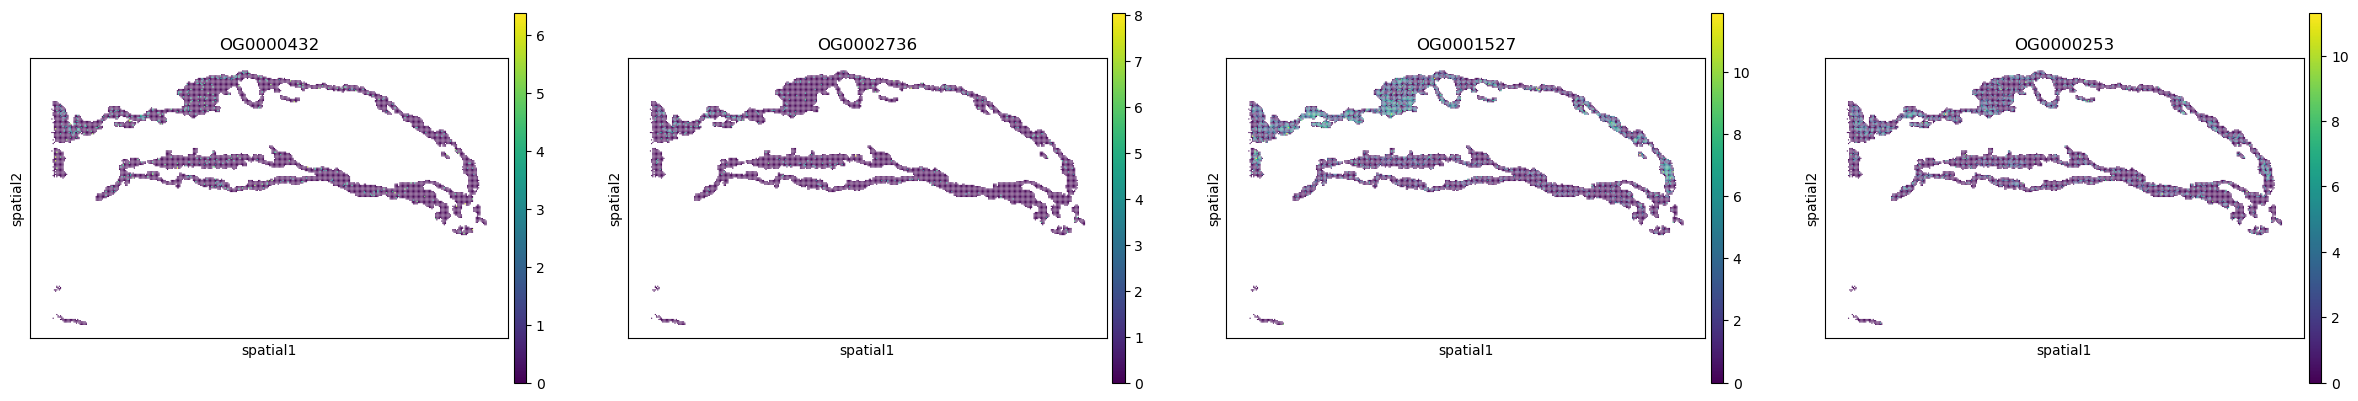

ClytiaMedusa-SC


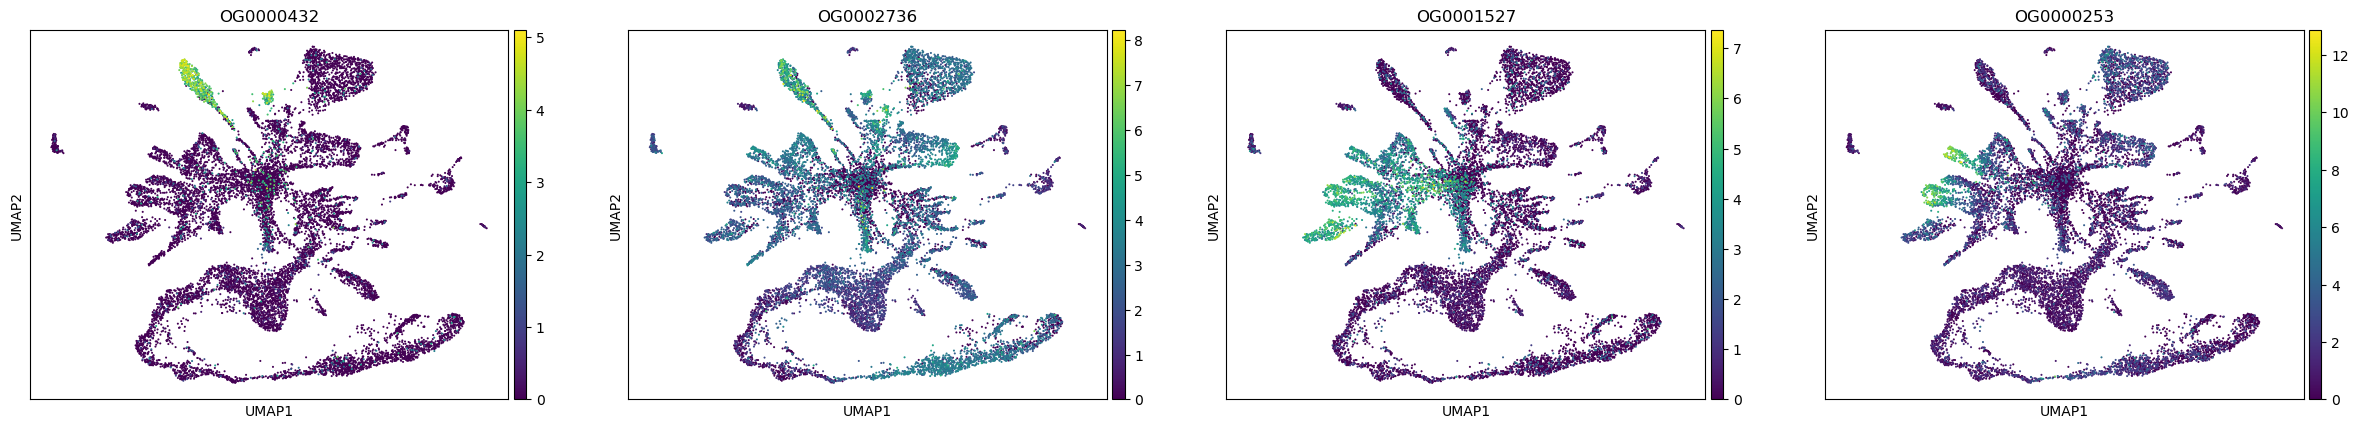


=== Nematocyte-related OGs markers ===
AureliaMargin-ST


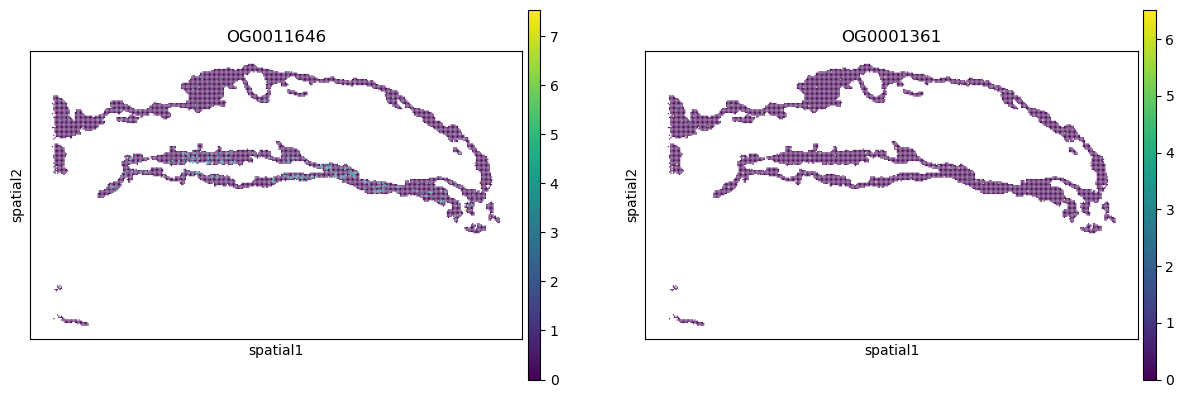

ClytiaMedusa-SC


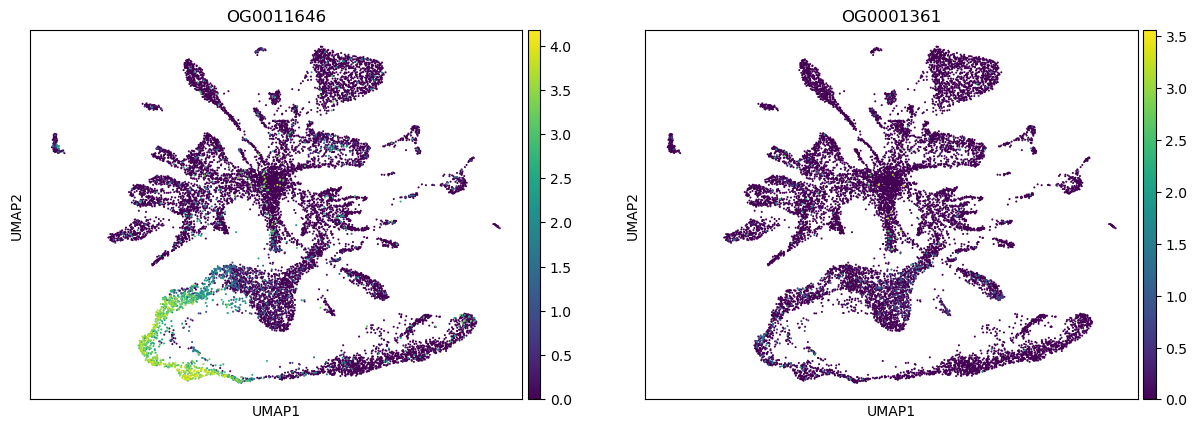


=== Neural-related OGs markers ===
AureliaMargin-ST


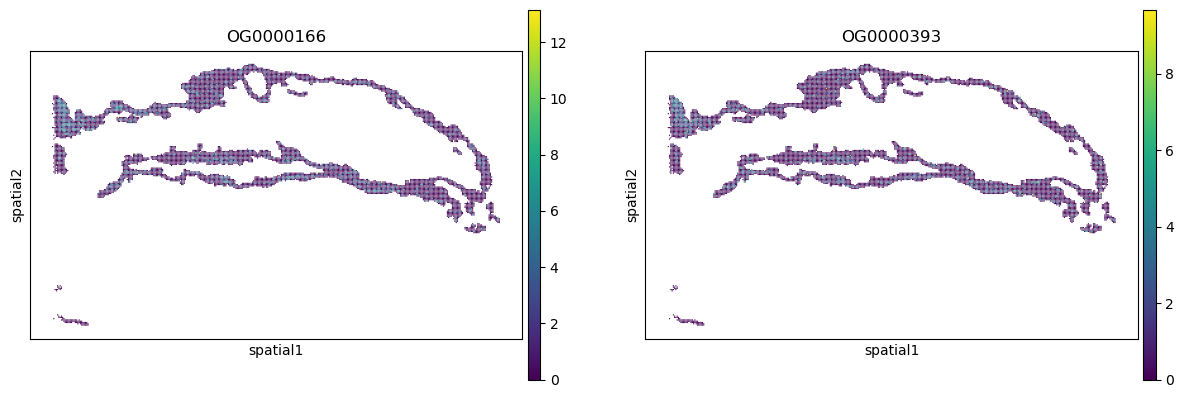

ClytiaMedusa-SC


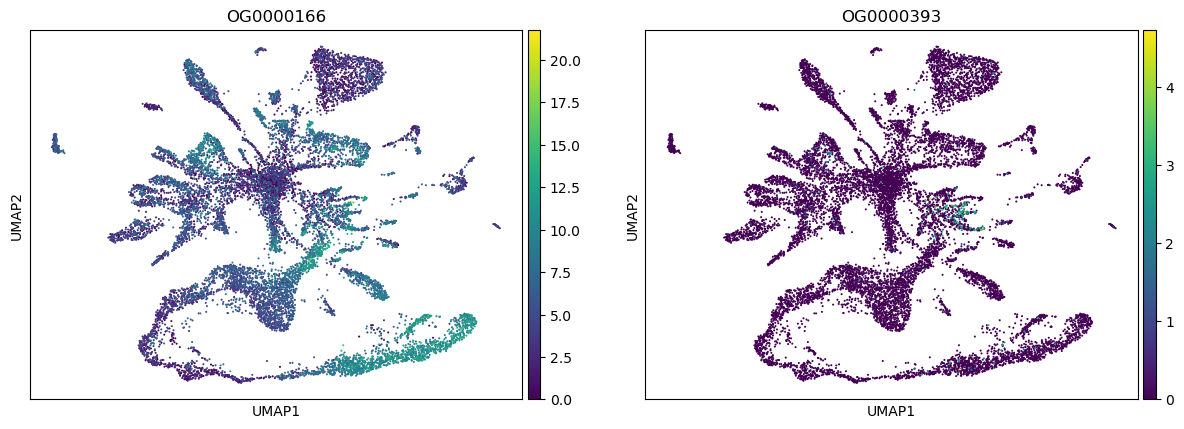

In [34]:
# Loop through cell-type marker groups and plot violins
for celltype, og_list in markers_dict.items():
    print(f"\n=== {celltype}-related OGs markers ===")

    # --- AureliaMargin-ST ---
    print('AureliaMargin-ST')
    sc.pl.spatial(st_AureliaMargin_og, color=og_list, spot_size=50)

    # --- ClytiaMedusa-SC ---
    print('ClytiaMedusa-SC')
    sc.pl.umap(sc_Clytia_og, color=og_list)

## 5.Spatial Annotation

In [35]:
# cluster_annos mapping
annos_map = {
    "c1": "Nematocyte-related",
    "c2": "Epidermal/Muscle-related",
    "c3": "Neural-related"
}

# cluster_annos added
st_AureliaMargin_og.obs["cluster_annos"] = st_AureliaMargin_og.obs["super_leiden"].map(annos_map)
st_AureliaMargin.obs["cluster_annos"] = st_AureliaMargin.obs["super_leiden"].map(annos_map)
print(st_AureliaMargin_og.obs["cluster_annos"].value_counts())
print(st_AureliaMargin.obs["cluster_annos"].value_counts())

cluster_annos
Nematocyte-related          3752
Epidermal/Muscle-related    2870
Neural-related              1924
Name: count, dtype: int64
cluster_annos
Nematocyte-related          3752
Epidermal/Muscle-related    2870
Neural-related              1924
Name: count, dtype: int64


In [36]:
st_AureliaMargin_og.uns["cluster_annos_colors"] = st_AureliaMargin_og.uns["super_leiden_colors"]
st_AureliaMargin.uns["cluster_annos_colors"] = st_AureliaMargin.uns["super_leiden_colors"]

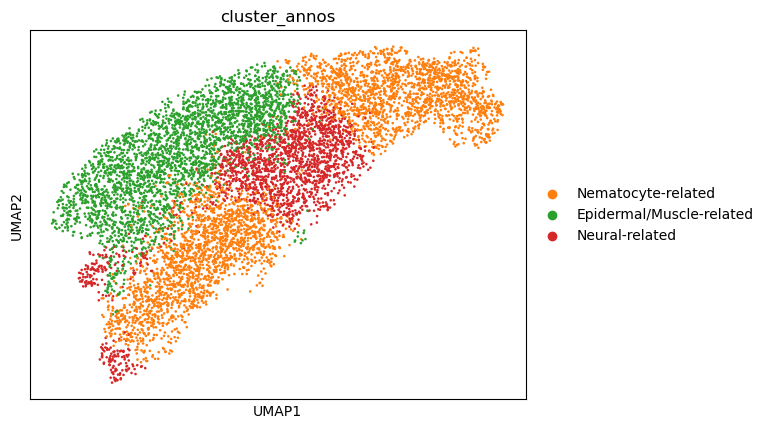

In [37]:
# cluster_annos UMAP
sc.pl.umap(st_AureliaMargin, color=['cluster_annos'])

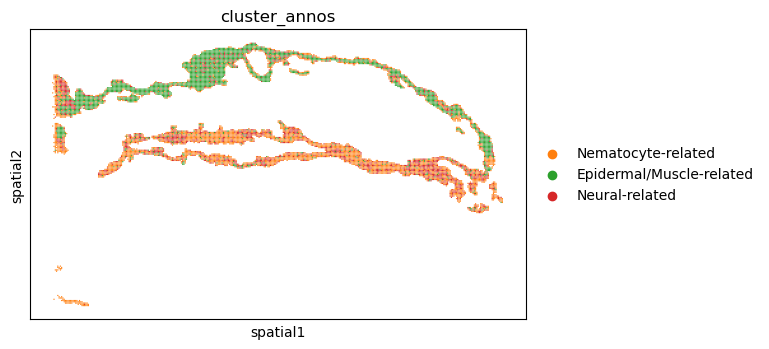

In [38]:
# cluster_annos Spatial
sc.pl.spatial(st_AureliaMargin, color=['cluster_annos'], spot_size=50)

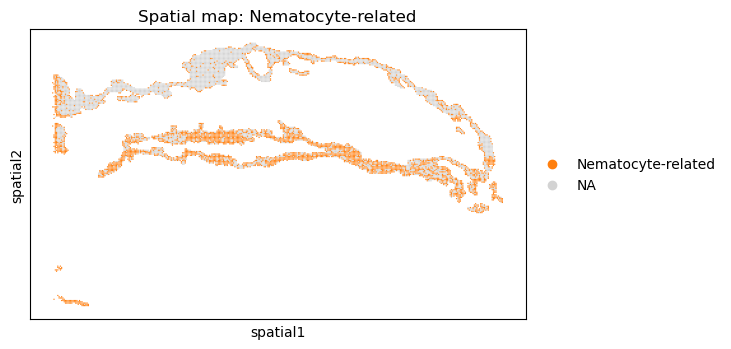

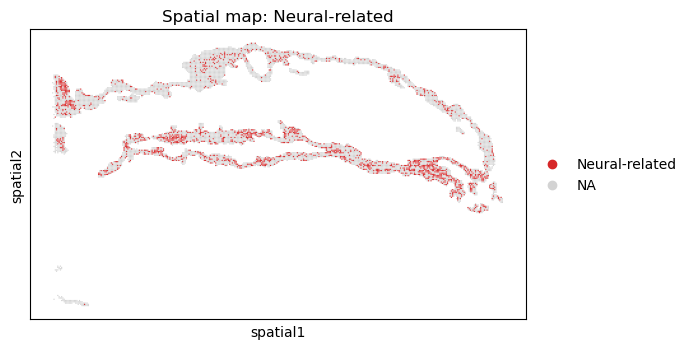

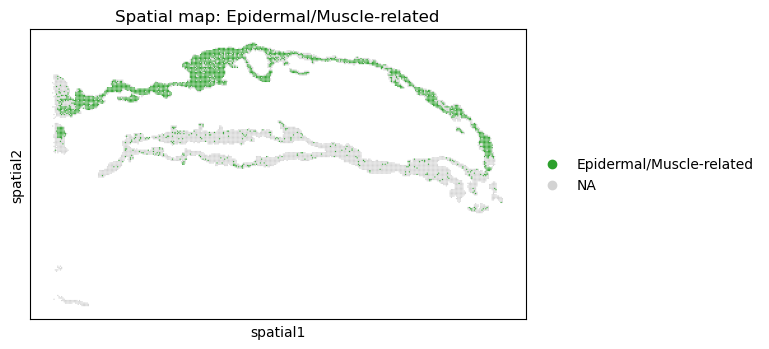

In [39]:
# each cluster in cluster_annos
celltypes = st_AureliaMargin.obs["cluster_annos"].unique().tolist()

for ct in celltypes:
    sc.pl.spatial(
        st_AureliaMargin,
        color="cluster_annos",
        groups=[ct],
        spot_size=50,
        title=f"Spatial map: {ct}"
    )


### st_AureliaMargin_og OGs markers

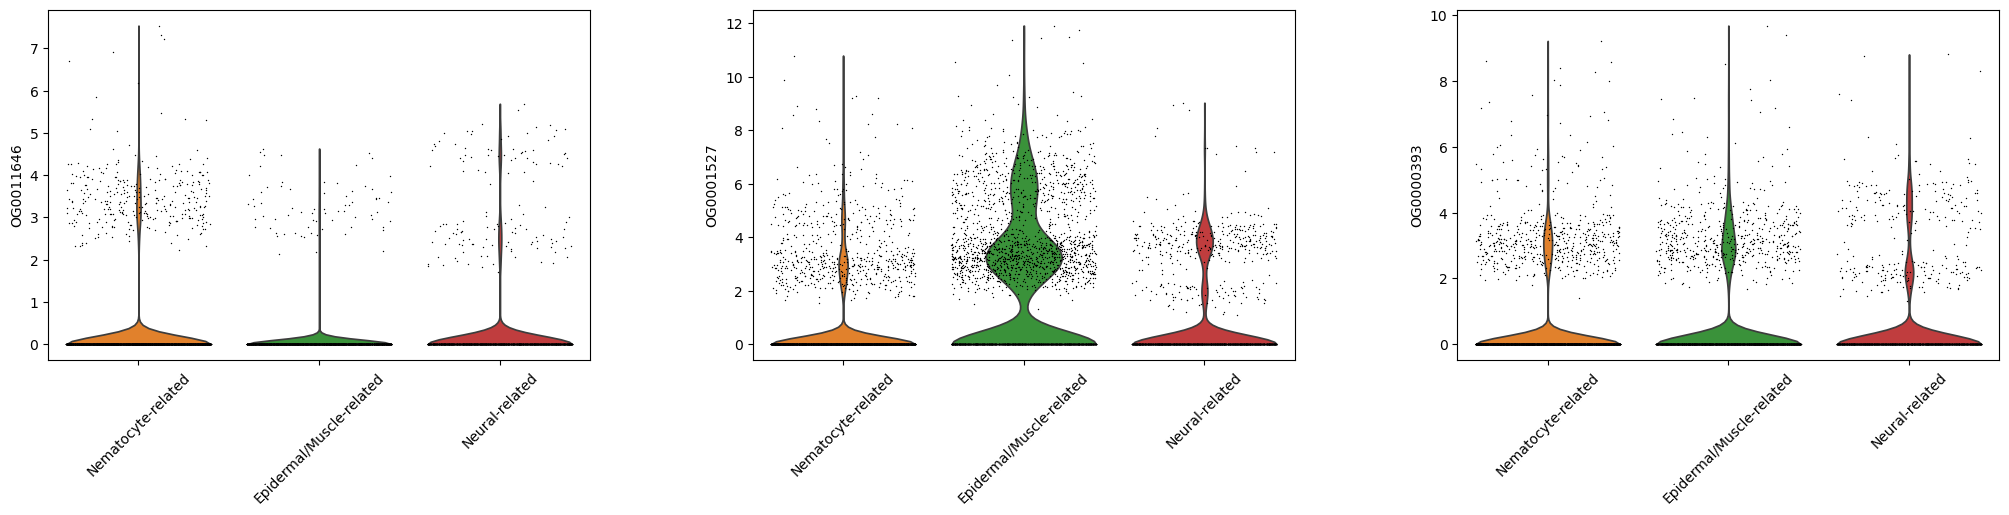

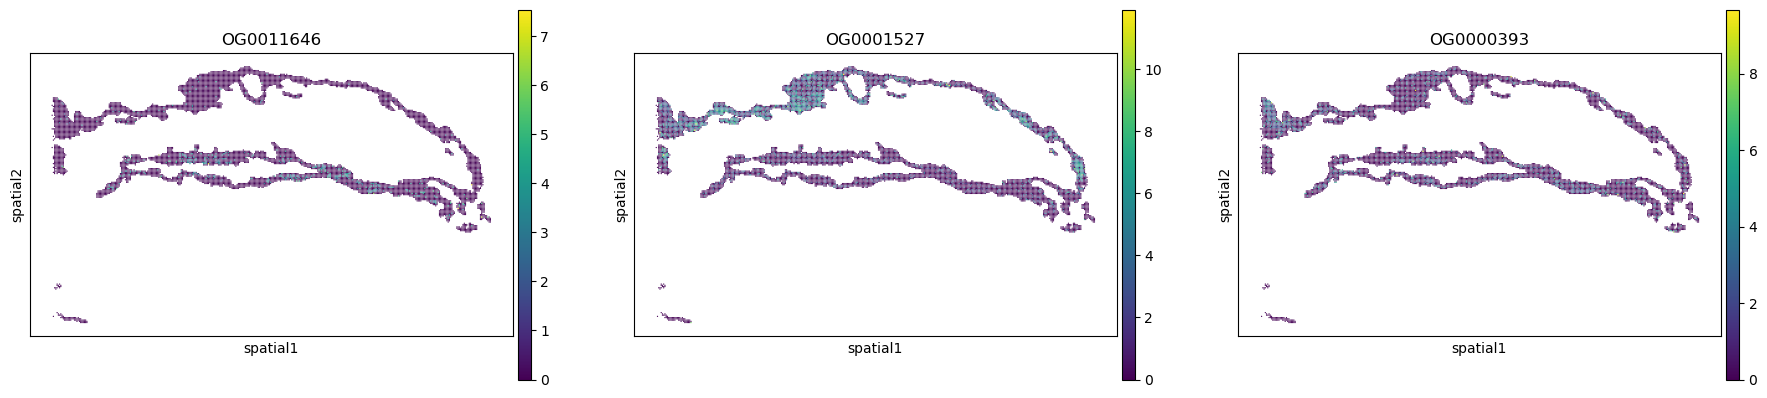

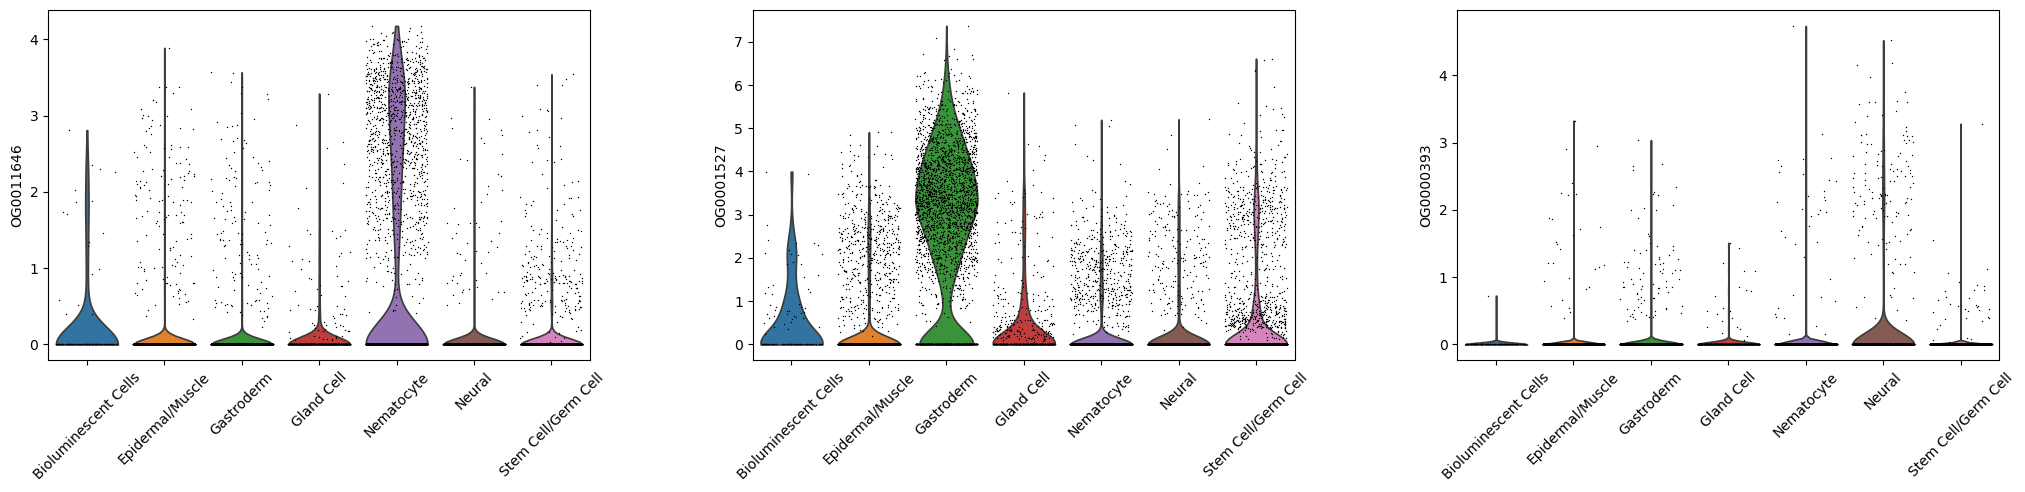

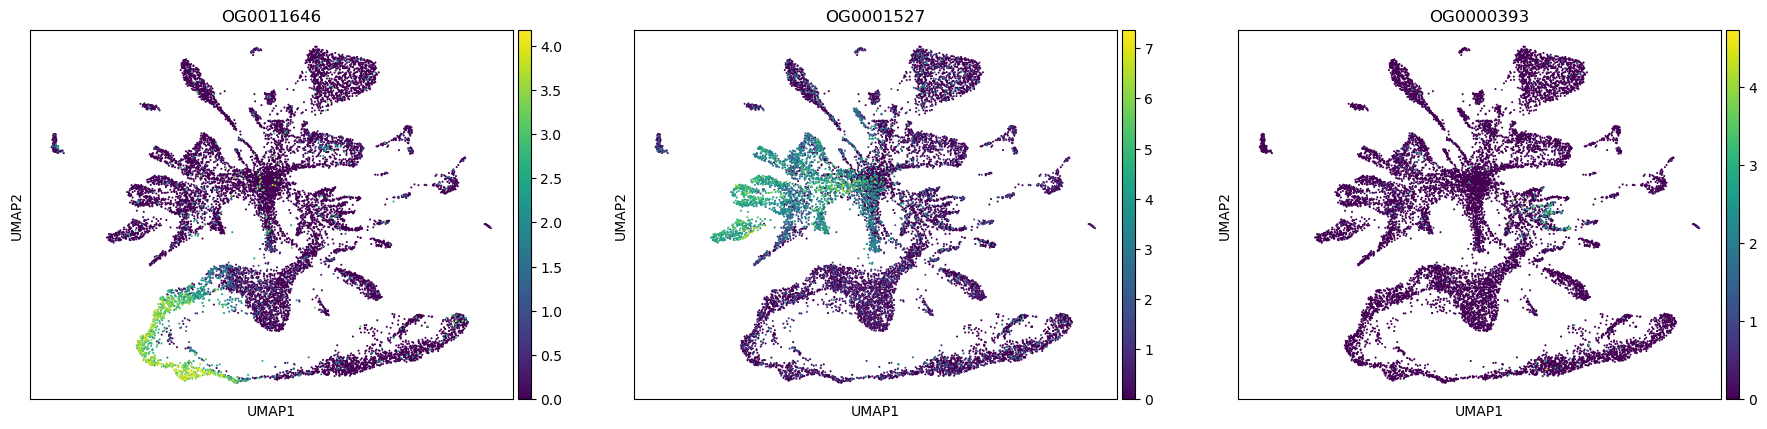

In [40]:
final_markers = ['OG0011646', 'OG0001527', 'OG0000393']
sc.pl.violin(st_AureliaMargin_og, keys=final_markers, groupby="cluster_annos", jitter=0.4, rotation=45, stripplot=True)
sc.pl.spatial(st_AureliaMargin_og, color=final_markers, spot_size=50)
sc.pl.violin(sc_Clytia_og, keys=final_markers, groupby="annos", jitter=0.4, rotation=45, stripplot=True)
sc.pl.umap(sc_Clytia_og, color=final_markers)

In [41]:
# Obtain cluster-specific differentially expressed genes
st_AureliaMargin_og.obs["cluster_annos"] = st_AureliaMargin_og.obs["cluster_annos"].astype("category")
# save rank_genes_groups
st_AureliaMargin_og.uns["rank_genes_groups_leiden"] = st_AureliaMargin_og.uns["rank_genes_groups"].copy()
sc.tl.rank_genes_groups(st_AureliaMargin_og, groupby="cluster_annos", method="wilcoxon")

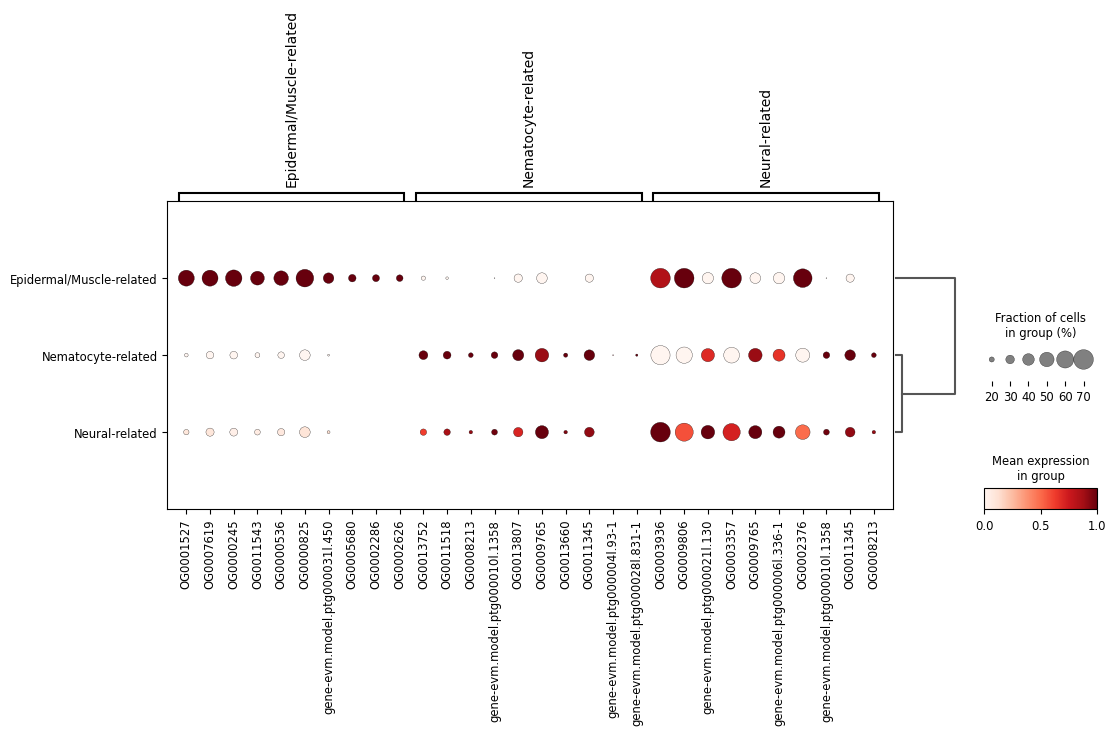

In [48]:
# Markers dotplot
sc.pl.rank_genes_groups_dotplot(
    st_AureliaMargin_og,
    groupby="cluster_annos",
    n_genes=10,
    standard_scale="var",
    color_map="Reds",
    dot_max=0.7,
    dot_min=0.1,
    figsize=(12, 4),
    show=True
)


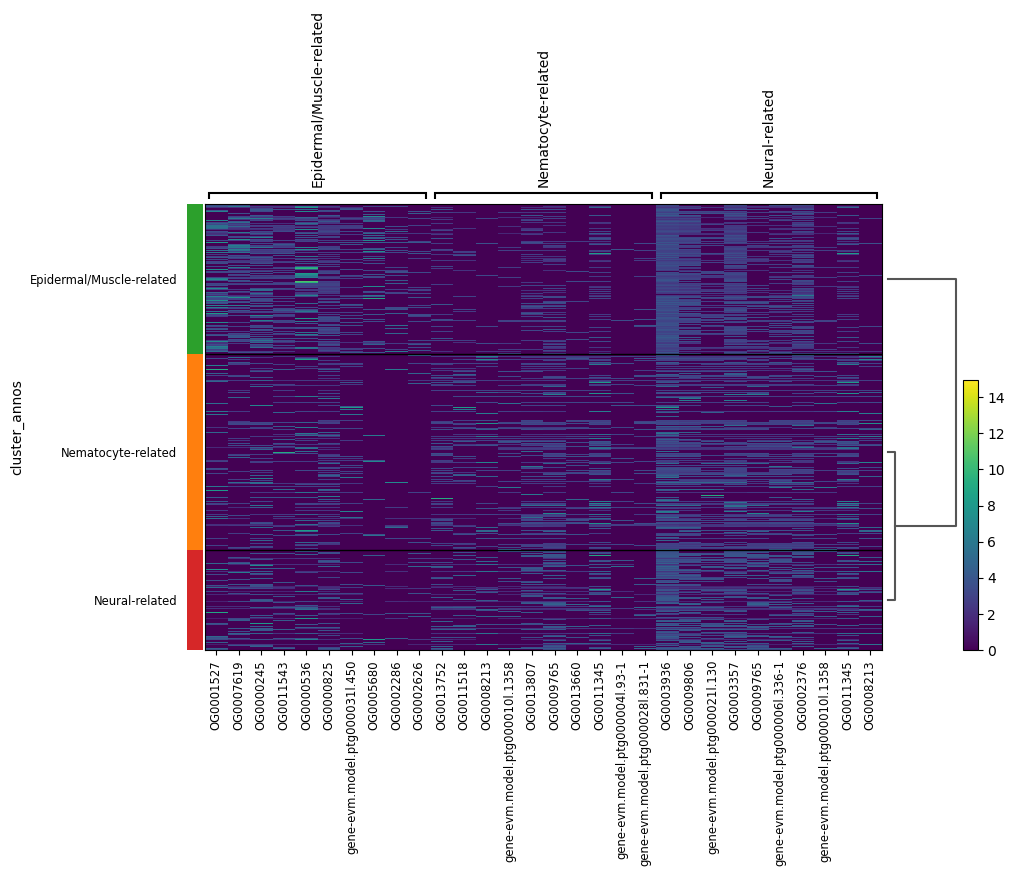

In [49]:
# Markers heatmap
sc.pl.rank_genes_groups_heatmap(
    st_AureliaMargin_og, groupby="cluster_annos", n_genes=10
)

### st_AureliaMargin Gene Markers

In [50]:
# 皮层肌肉相关 OG0001527
# gene-evm.model.ptg000021l.289#TPM2-PODCA#Q9U5M4,OG0002736
# XLOC-003006#APLP-LOCMI#Q9U943,OG0001527
# XLOC-003850#APLP-LOCMI#Q9U943,OG0001527
# XLOC-025489#APOB-RAT#Q7TMA5,OG0001527
# gene-evm.model.ptg000007l.745#APOB-RAT#Q7TMA5,OG0001527
# gene-evm.model.ptg000011l.231#APLP-LOCMI#Q9U943,OG0001527

# 神经细胞相关 OG0000393
# XLOC-002149#XLOC-002149,OG0000393
# XLOC-009553#SNX27-MOUSE#Q3UHD6,OG0000393
# XLOC-013940#HCN2-HUMAN#Q9UL51,OG0000393
# XLOC-022104#CNGA2-BOVIN#Q03041,OG0000393
# XLOC-024044#CNGA3-MOUSE#Q9JJZ8,OG0000393
# XLOC-025648#HCN4-HUMAN#Q9Y3Q4,OG0000393
# gene-evm.model.ptg000021l.24#ACDSB-RAT#P70584,OG0000393

# 刺细胞相关 OG0011646
# XLOC-021328#XLOC-021328,OG0011646
# gene-evm.model.ptg000018l.390#gene-evm.model.ptg000018l.390,OG0011646

In [51]:
gene_dict = {
    "Nematocyte-related": [
        "XLOC-021328#XLOC-021328",
        # "gene-evm.model.ptg000018l.390#gene-evm.model.ptg000018l.390"
    ],

    "Epidermal/Muscle-related": [
        # "gene-evm.model.ptg000021l.289#TPM2-PODCA#Q9U5M4",
        "XLOC-003006#APLP-LOCMI#Q9U943",
        "XLOC-003850#APLP-LOCMI#Q9U943",
        "XLOC-025489#APOB-RAT#Q7TMA5",
        # "gene-evm.model.ptg000007l.745#APOB-RAT#Q7TMA5",
        # "gene-evm.model.ptg000011l.231#APLP-LOCMI#Q9U943"
    ],

    "Neural-related": [
        # "XLOC-002149#XLOC-002149",
        "XLOC-009553#SNX27-MOUSE#Q3UHD6",
        "XLOC-013940#HCN2-HUMAN#Q9UL51",
        "XLOC-022104#CNGA2-BOVIN#Q03041",
        "XLOC-024044#CNGA3-MOUSE#Q9JJZ8",
        "XLOC-025648#HCN4-HUMAN#Q9Y3Q4",
        # "gene-evm.model.ptg000021l.24#ACDSB-RAT#P70584"
    ]
}

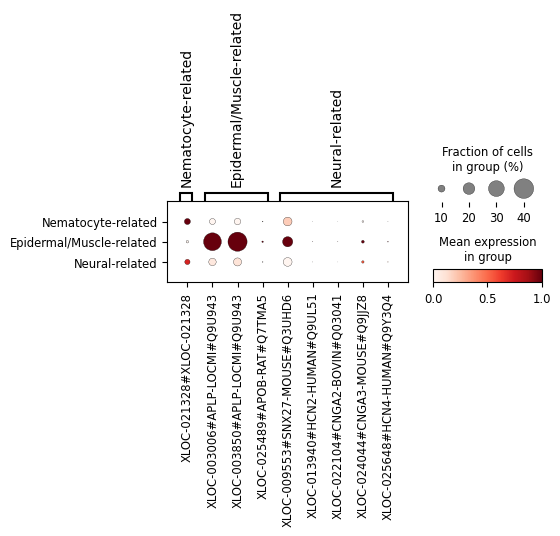

In [55]:
# Markers dotplot
sc.pl.dotplot(
    st_AureliaMargin,
    var_names=gene_dict,
    groupby="cluster_annos",
    standard_scale="var"
)